In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [52]:
sys.path.append('../../')
import compute_preprocessing

In [53]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [54]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [55]:
import tensorflow as tf

In [56]:
import pugna.layers
import pugna.activations

In [57]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [58]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e5/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e5/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e5/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e5/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e5/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params


def preload_amp_1e3(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

# def preload_phase(data_dir):

#     pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
#     with open(pkl_filename, 'rb') as file:
#         times_scaler = pickle.load(file)
    
    
#     times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
#     times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
#     ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/phase.npy"))
#     ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/phase_preprocessing_params.npz"))
    
#     ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
#     coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
# #     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
#     return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [59]:
mfiles = sorted(glob.glob("00*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['001/model.h5', '002/model.h5', '003/model.h5', '004/model.h5', '005/model.h5']


In [60]:
models.keys()

odict_keys(['001', '002', '003', '004', '005'])

In [61]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [62]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)

# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp_1e3(data_dir=data_dir)

# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_phase(data_dir=data_dir)

In [63]:
coords.shape

(3, 100000)

In [64]:
ys.shape

(100000, 1099)

In [65]:
times

array([-499.50433896, -499.00433896, -498.50433896, ...,   48.49566104,
         48.99566104,   49.49566104])

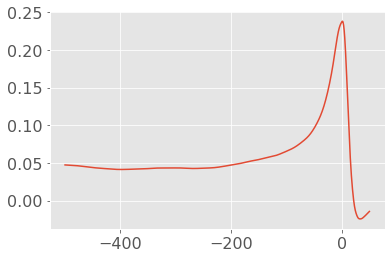

In [66]:
plt.figure()
plt.plot(times, ys[0])

In [67]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models, ylim=None, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
#         yhats[k] = yhat[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k, ls='--')
    if xlim:
        plt.xlim(*xlim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.yscale('log')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
#         plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
        plt.plot(times, (v-ys_raw[index]), label=f"% (data-{k})")
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.ylim(-10, 10)
#     plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [68]:
# np.where((coords[1] > 0.98) & (coords[2] > 1.3) & (coords[2] < 1.7))
np.where((coords[0] > 2.9) & (coords[1] > 0.98) & (coords[2] > 1.3) & (coords[2] < 1.7))

(array([ 7790,  8918, 12045, 16869, 25415, 30234, 31396, 52662, 68875,
        85296]),)

In [69]:
# np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

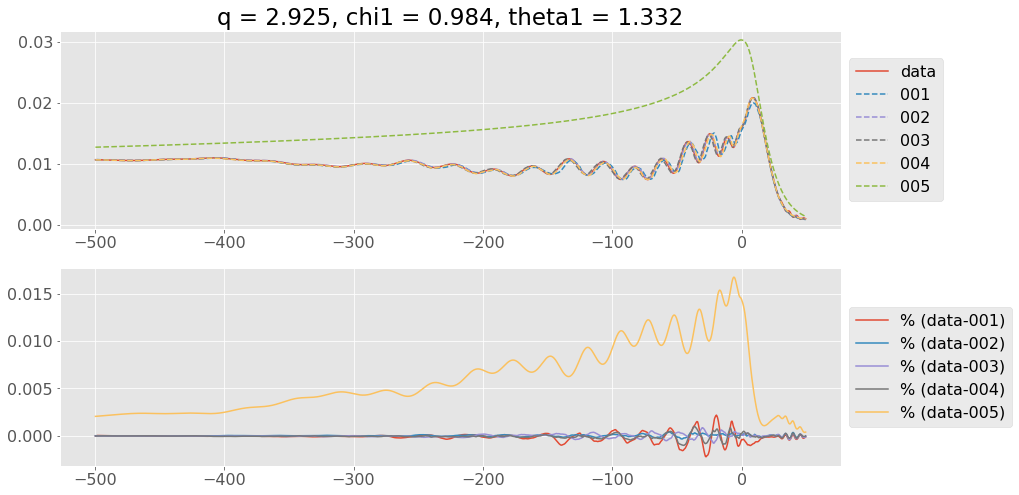

In [70]:
compare_models(index=52662, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [71]:
compare_models(index=239, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [72]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'005':models['005']})

In [73]:
compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [74]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# yhat = models['008'].predict(Xhat).T

In [75]:
# yhat.shape

In [76]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
    max_loop = 1000
#     max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
#             errors[k][index] = np.max(100*(ys_raw[index]-yhats[k][index])/ys_raw[index])
            errors[k][index] = np.max(np.abs(ys_raw[index]-yhats[k][index]))
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [77]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
CPU times: user 2.41 ms, sys: 3.46 ms, total: 5.87 ms
Wall time: 4.94 ms


In [78]:
# errors['008'].shape

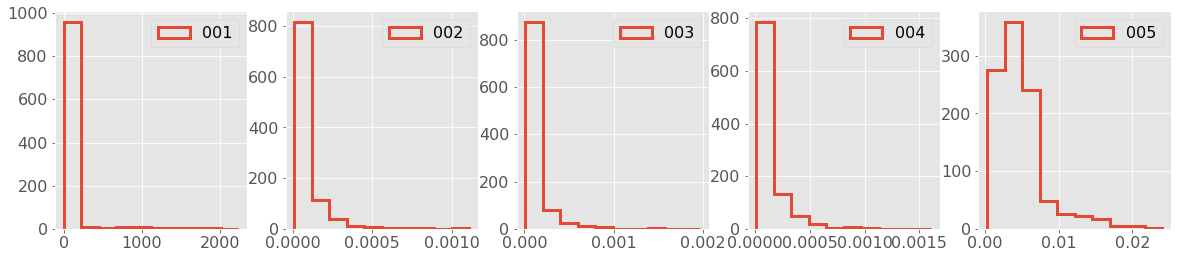

In [79]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [80]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

001: 2233.931823847081
002: 0.0011122543520899336
003: 0.001971151444454951
004: 0.0016093010223195044
005: 0.02404182993039909


In [81]:
max_idx

{'001': (array([353]),),
 '002': (array([655]),),
 '003': (array([655]),),
 '004': (array([99]),),
 '005': (array([460]),)}

Text(0, 0.5, '$\\theta_1$')

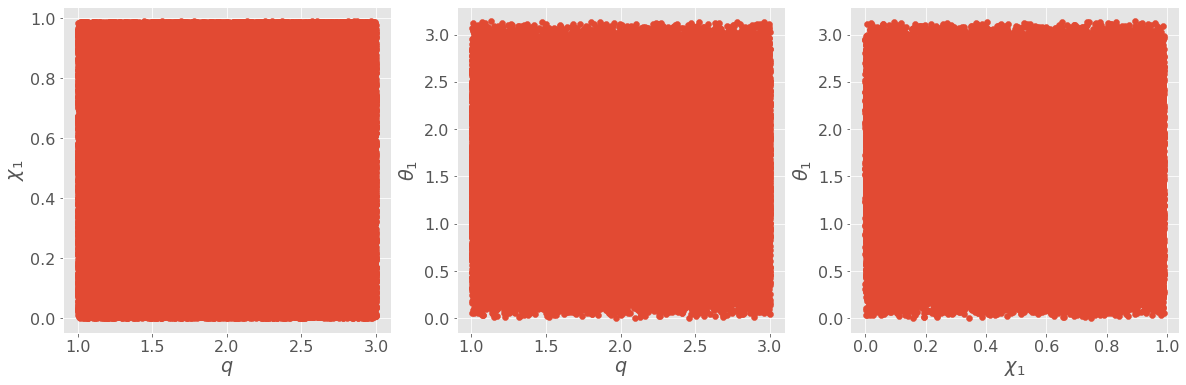

In [82]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1])
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2])
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2])
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

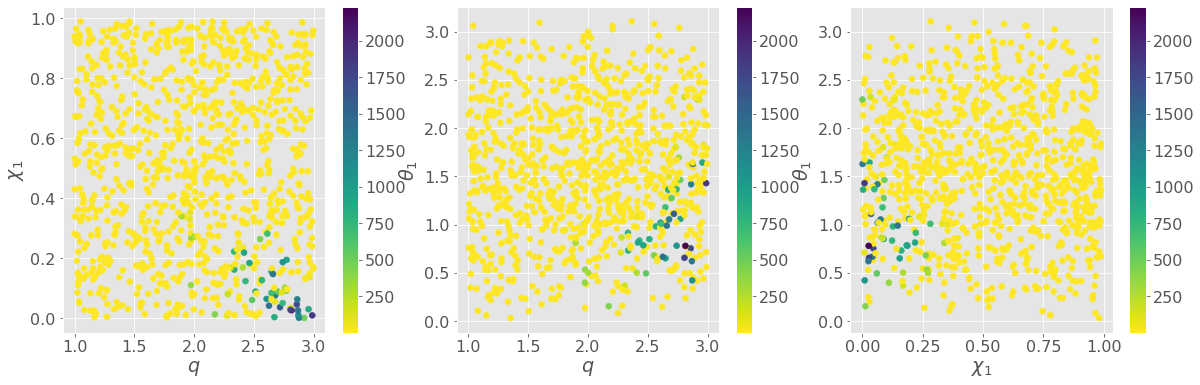

In [83]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0][:1000], coords[1][:1000], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0][:1000], coords[2][:1000], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1][:1000], coords[2][:1000], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

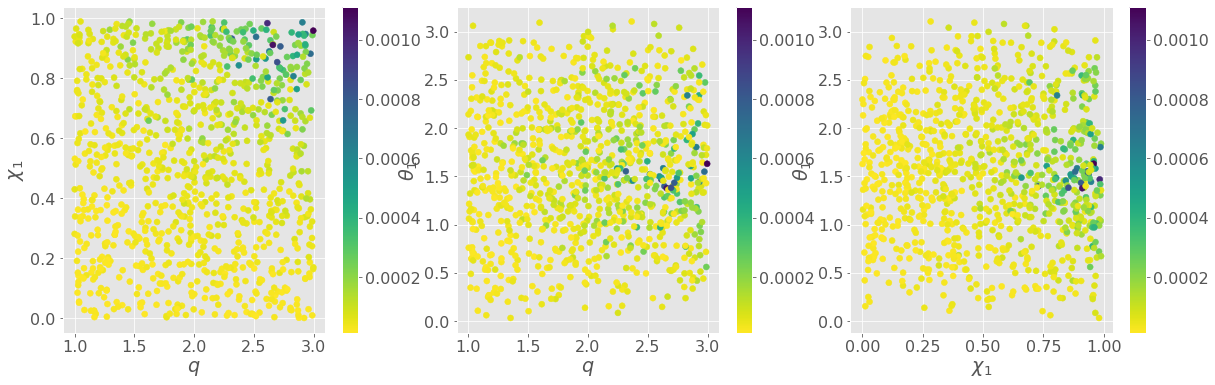

In [84]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0][:1000], coords[1][:1000], c=errors['002'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0][:1000], coords[2][:1000], c=errors['002'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1][:1000], coords[2][:1000], c=errors['002'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

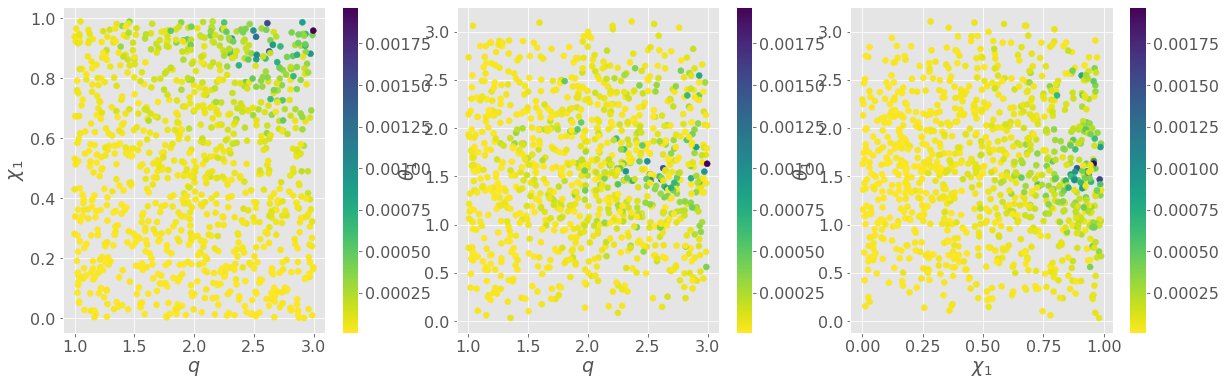

In [85]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0][:1000], coords[1][:1000], c=errors['003'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0][:1000], coords[2][:1000], c=errors['003'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1][:1000], coords[2][:1000], c=errors['003'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [86]:
worst_cases_values = np.flip(np.sort(np.abs(errors['002'])))[:10]
# worst_cases_values = np.flip(np.sort(np.abs(errors['002'])))[-100:-90]
worst_cases_idx = np.array([np.where(np.abs(errors['002']) == w_c)[0][0] for w_c in worst_cases_values])

In [87]:
worst_cases_values

array([0.00111225, 0.00106088, 0.00097939, 0.00084496, 0.00079632,
       0.00079132, 0.00077735, 0.00072285, 0.00071136, 0.00064324])

In [88]:
worst_cases_idx

array([655, 634,  99, 900, 108, 479,  32, 348,  14, 531])

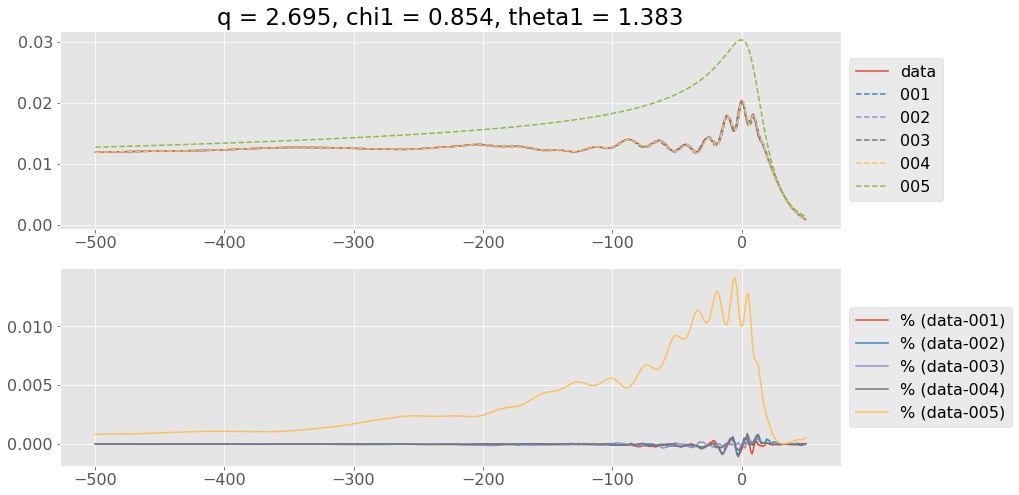

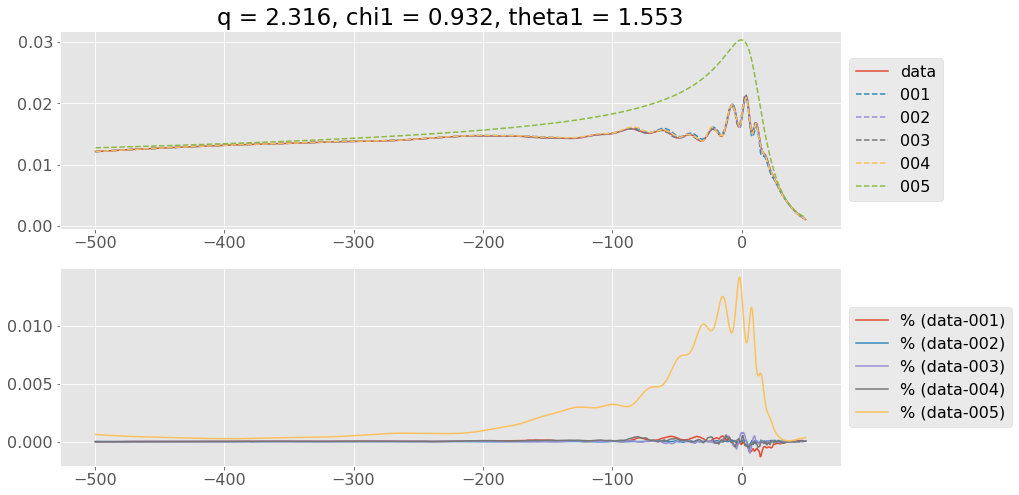

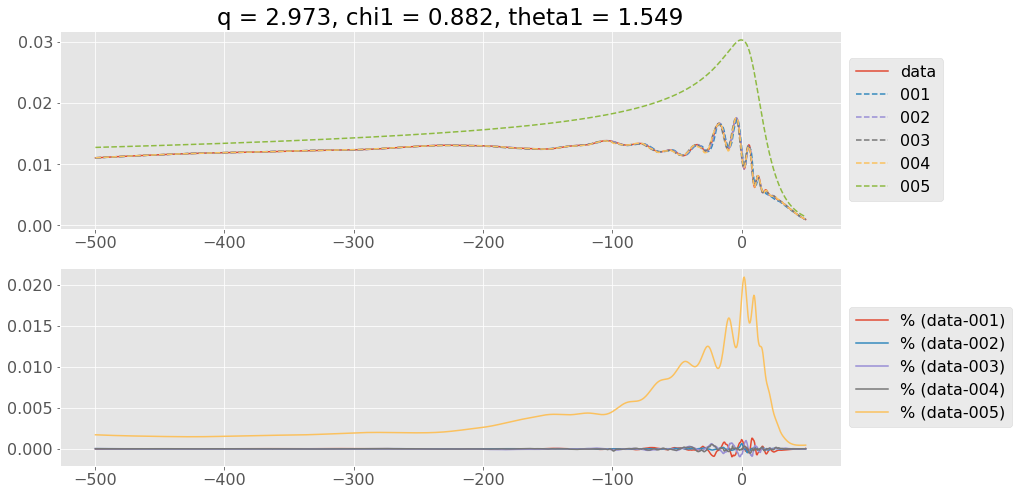

In [89]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models=models)

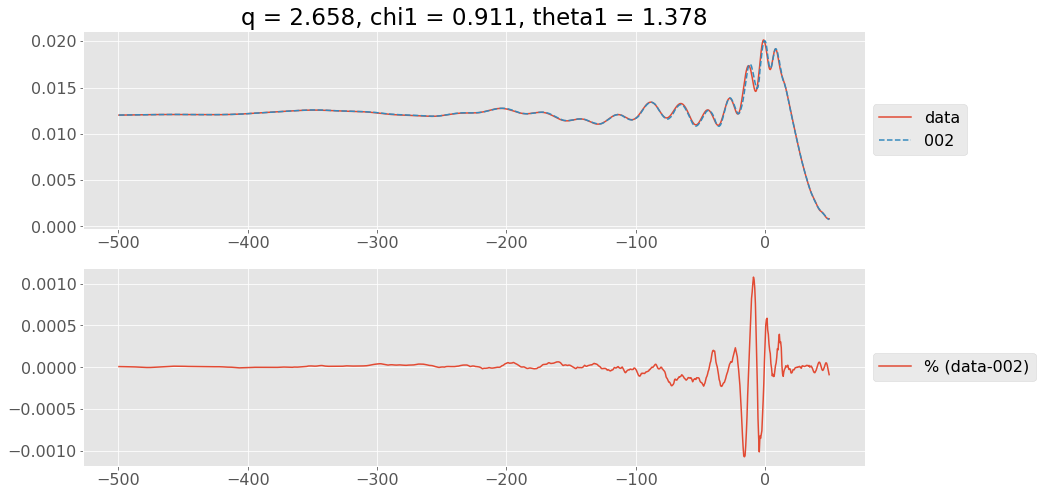

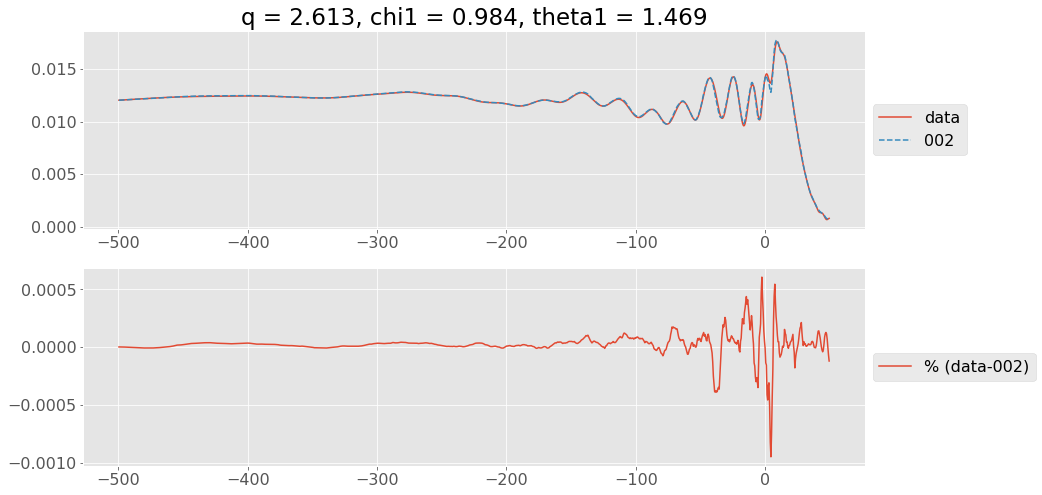

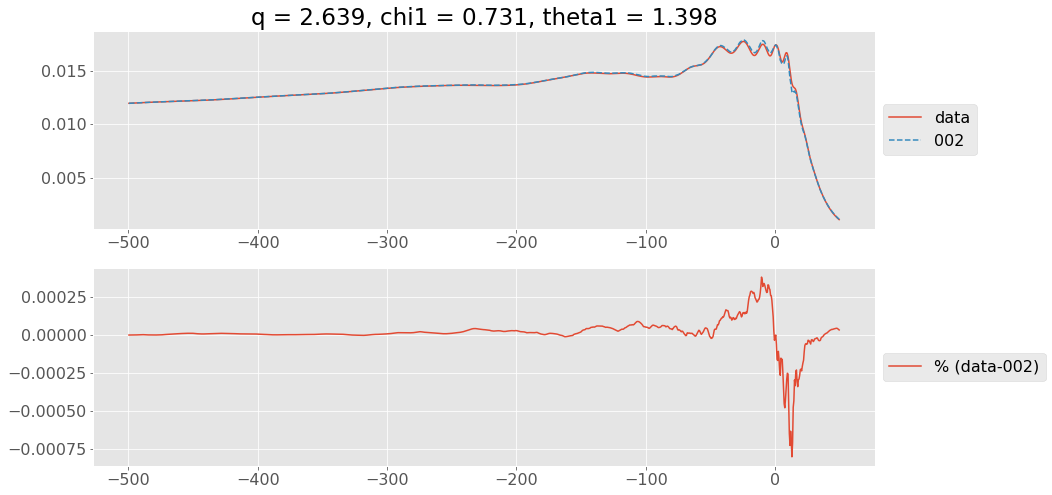

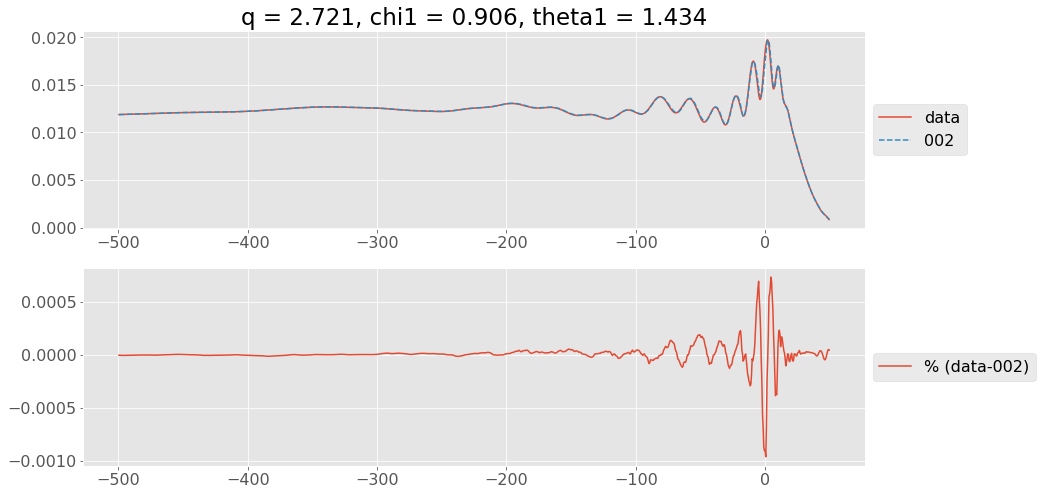

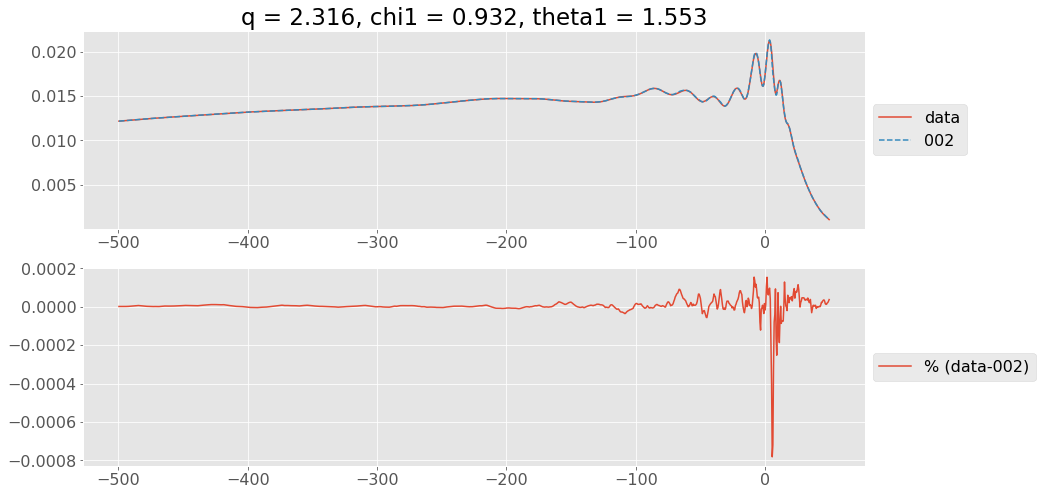

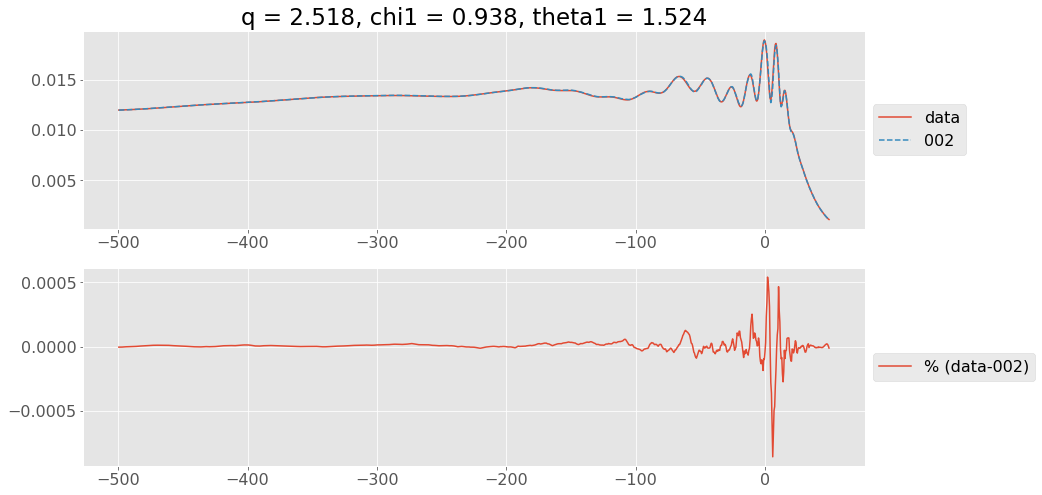

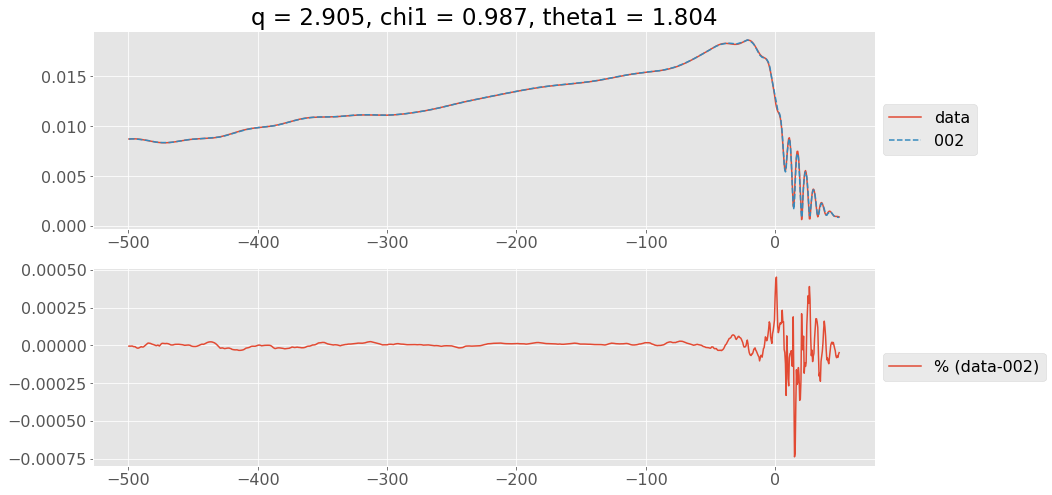

In [90]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models={'002':models['002']})

# try batching

In [91]:
q = 1
chi1 = 0.2
theta1 = 1.3
Xhat1 = compute_model_input(times_scaled, q, chi1, theta1)
# Xhat1 = np.expand_dims(Xhat1, axis=0)


q = 2.3
chi1 = 0.9
theta1 = 1.78
Xhat2 = compute_model_input(times_scaled, q, chi1, theta1)
# Xhat2 = np.expand_dims(Xhat2, axis=0)

In [92]:
Xhat1.shape

(1099, 4)

In [93]:
Xhat2.shape

(1099, 4)

In [94]:
Xhat_batch = np.stack((Xhat1, Xhat2), axis=0)

In [95]:
Xhat_batch.shape

(2, 1099, 4)

In [96]:
Xhat_batch[0].shape

(1099, 4)

In [97]:
yhat = models['002'].predict(Xhat_batch[0]).T

In [98]:
yhat.shape

(1, 1099)

In [106]:
# yhat = models['002'].predict(Xhat_batch).T

In [100]:
Xhat_batch_v2 = np.concatenate((Xhat1, Xhat2), axis=0)

In [101]:
Xhat_batch_v2.shape

(2198, 4)

In [102]:
yhat = models['002'].predict(Xhat_batch_v2).T

In [103]:
yhat.shape

(1, 2198)

In [104]:
yhat_re = yhat.reshape(2, 1099)

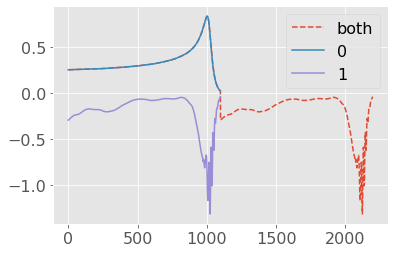

In [115]:
plt.figure()
plt.plot(yhat[0], label='both', ls='--')
plt.plot(yhat_re[0], label='0')
plt.plot(yhat_re[1], label='1')
plt.legend()

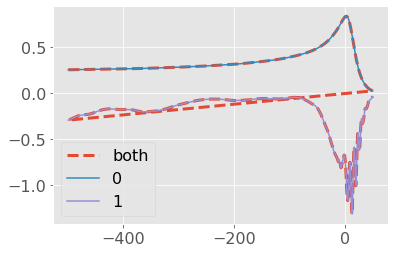

In [121]:
plt.figure()
plt.plot(np.concatenate((times,times)), yhat[0], label='both', ls='--', lw=3)
plt.plot(times, yhat_re[0], label='0')
plt.plot(times, yhat_re[1], label='1')
plt.legend()